Input Shape: (8192, 8192) | Size: 268.44 MB

--- Benchmarking Eager Execution ---
Eager Time: 5.71861 s

--- Benchmarking XLA Compiled Execution ---
JIT Time:   1.94461 s
Speedup:    2.94x

--- Inspecting Compiler IR (HLO) ---
Detected 'fusion' instruction in HLO.
The compiler collapsed the element-wise ops into a single kernel.
Sample Instruction: ROOT %multiply_add_fusion = f32[8192,8192]{1,0} fusion(%x.1), kind=kLoop, calls=%fused_computation, metadata={op_name="jit(custom_activation)/add" source_file="/tmp/ipython-input-2561134414.py" source_line=11 source_end_line=11 source_column=11 source_end_column=22}, backend_config={"outer_dimension_partitions":["2"]}...


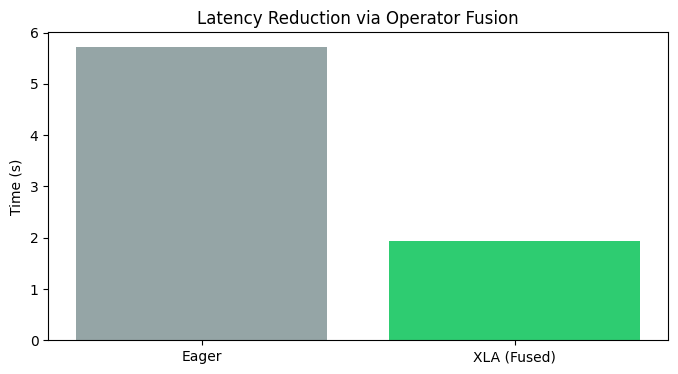

In [1]:
import jax
import jax.numpy as jnp
import time
import numpy as np
import matplotlib.pyplot as plt

# 1. Define a Memory-Bound Activation Function
# ---------------------------------------------------------
# A sequence of element-wise ops: Tanh -> Sin -> Multiply -> Add
def custom_activation(x):
    return jnp.tanh(x) * jnp.sin(x) + (x * 0.5)

# Large tensor to hit memory limits
N = 8192
x = jax.random.normal(jax.random.key(0), (N, N))
print(f"Input Shape: {x.shape} | Size: {x.nbytes / 1e6:.2f} MB")

# 2. Benchmark Eager Execution
# ---------------------------------------------------------
print("\n--- Benchmarking Eager Execution ---")

start = time.time()
# block_until_ready() is required because JAX execution is asynchronous
res_eager = custom_activation(x).block_until_ready()
end = time.time()
eager_time = end - start
print(f"Eager Time: {eager_time:.5f} s")

# 3. Benchmark XLA Compiled Execution
# ---------------------------------------------------------
print("\n--- Benchmarking XLA Compiled Execution ---")
jitted_activation = jax.jit(custom_activation)

# Warmup run to handle compilation overhead
_ = jitted_activation(x).block_until_ready()

# Timed Run
start = time.time()
res_jit = jitted_activation(x).block_until_ready()
end = time.time()
jit_time = end - start

print(f"JIT Time:   {jit_time:.5f} s")
print(f"Speedup:    {eager_time / jit_time:.2f}x")

# 4. Inspecting the HLO IR
# ---------------------------------------------------------
# Lower the function to HLO (High Level Optimizer) IR to verify fusion.
print("\n--- Inspecting Compiler IR (HLO) ---")

hlo_text = jitted_activation.lower(x).compile().as_text()

if "fusion" in hlo_text:
    print("Detected 'fusion' instruction in HLO.")
    print("The compiler collapsed the element-wise ops into a single kernel.")

    # Print a snippet for verification
    lines = hlo_text.split('\n')
    fusion_lines = [line for line in lines if 'fusion' in line]
    print(f"Sample Instruction: {fusion_lines[0].strip()}...")
else:
    print("No fusion detected.")

# Simple visualization
plt.figure(figsize=(8, 4))
plt.bar(['Eager', 'XLA (Fused)'], [eager_time, jit_time], color=['#95a5a6', '#2ecc71'])
plt.title('Latency Reduction via Operator Fusion')
plt.ylabel('Time (s)')
plt.show()